In [1]:
import os
import os.path
import gdown

import math
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

from torchvision import datasets
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import verify_str_arg

from torchsummary import summary

from tqdm import tqdm

# Data exploration

In [2]:
# Helper class to download dataset
class FossilNET(ImageFolder):
    """`FossilNET <https://github.com/softwareunderground/fossilnet>`_ Dataset.
    Modified from https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py
    Args:
        root (string): Root directory of dataset where ``EMNIST/processed/training.pt``
            and  ``EMNIST/processed/test.pt`` exist.
        split (string): The dataset has 3 different splits: ``train``, ``val``,
            ``test``. This argument specifies
            which one to use.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    url = 'https://drive.google.com/uc?id=1_2TK0hC_b3mliXajPcobV-eq-3HNXd3q'
    folder = 'fossilnet-png-224px'
    md5 = '83e4f09fc78e3fd996c4e611c2653bf9'
    splits = ('train', 'val', 'test')

    def __init__(self, root, split, download=False, **kwargs):
        self.split = verify_str_arg(split, "split", self.splits)
        self.basedir = root
        os.makedirs(self.basedir, exist_ok=True)

        if self.split == "train":
            self.root = self.train_folder
        elif self.split == "val":
            self.root = self.val_folder
        elif self.split == "test":
            self.root = self.test_folder
        else:
            raise NotImplementedError

        if download:
            self.download()

        super(FossilNET, self).__init__(self.root, **kwargs)

    def __getitem__(self, index):
        item = super().__getitem__(index)
        return item[0]

    @property
    def train_folder(self):
        return os.path.join(self.basedir, self.folder, 'train')

    @property
    def val_folder(self):
        return os.path.join(self.basedir, self.folder, 'val')

    @property
    def test_folder(self):
        return os.path.join(self.basedir, self.folder, 'test')

    def _check_exists(self):
        return os.path.exists(self.root)

    def download(self):
        """Download the FossilNET data if it doesn't exist already."""
        if self._check_exists():
            return

        print('Downloading...')
        # download files
        gdown.download(self.url, os.path.join(self.basedir, self.__class__.__name__+".zip"), quiet=False)
        # Unzipping the file
        import zipfile
        with zipfile.ZipFile(os.path.join(self.basedir, self.__class__.__name__+".zip"), 'r') as zip_ref:
            zip_ref.extractall(self.basedir)
        print('Done!')

    def extra_repr(self):
        return "Split: {}".format(self.split)

In [3]:
# Data transformation
transform = transforms.Compose([
        transforms.Resize(75),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
])

# Get the training, validation and test data
training_data = FossilNET('dataset', 'train', transform=transform, download=True)
print(f'Training samples: {len(training_data)}')
print(f'Training sample size: {training_data[0].shape}')

# Randomly select a small subset of samples
# training_data = torch.utils.data.Subset(training_data, np.random.choice(len(training_data), 600, replace=False))

Training samples: 2000
Training sample size: torch.Size([3, 64, 64])


In [4]:
# Helper function to display results
def display_image_grid(images, num_rows, num_cols, title_text=None):

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.))
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, images):
        ax.imshow(im.permute(1, 2, 0), interpolation='none')
        ax.axis("off")

    if title_text is not None:
        plt.suptitle(title_text, fontsize=20)

    plt.show()

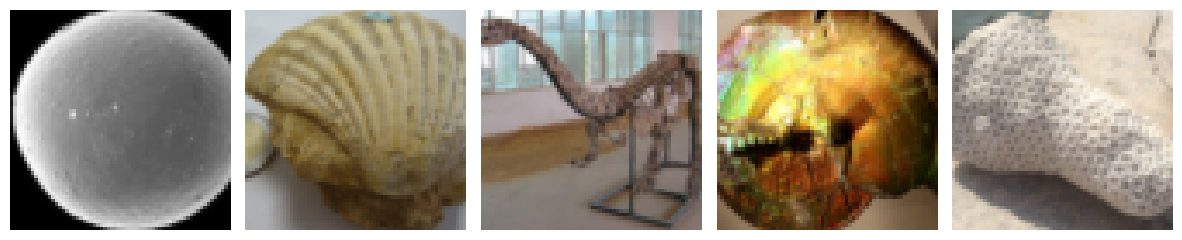

In [5]:
# Visualize some sample images
images = []
cols, rows = 5, 1
for i in range(cols * rows):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img = training_data[sample_idx]
    images.append(img)
display_image_grid(images, rows, cols)

# Image Generation using Variational Autoencoders

The goal of Autoencoders was to generate latent vectors which are easily decodable back to the original image. But this can cause the latent space to become disjoint and non-continous.

Variational Autoencoders were introduced to remedy this. Variational Autoencoders are trained to learn the probability distribution that models the input data. In varional autoencoders, the inputs are mapped to a probability distribuion over latent vectors. Typically, this probability distribution is set to standard normal distribution. So, there are two targets in VAEs: one to minimize the reconstruction loss and two to minimize the KL divergence between the probilitistic encoder and standard normal distribution.


!["Variational Autoencoder Architecture"](https://blog.bayeslabs.co/assets/img/vae-gaussian.png)

<p align = "center">
Fig.1 - Variational Autoencoder Architecture
(<a href=https://blog.bayeslabs.co/2019/06/04/All-you-need-to-know-about-Vae">
source
</a>)
</p>

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Here, we will define a model for a Variational Autoencoder. It is mostly similar to Autoencoders with a few differences. Instead of the encoder outputing a deterministic latent space representation like in autoencoders, the encoder will now output a mean and log variance vector. The latent space representation will then be sampled using them. We output log variance instead of just variance because the varaince always has to be postive.

The docoder is same as in autoencoders.

For sampling the latent space representation, we use a reparameterization trick so that it is possible to backpropagate. The basic idea is given below in the Fig 2.

!["Reparameteriztion Trick"](https://blog.bayeslabs.co/assets/img/vae_part_1_1.png)

<p align = "center">
Fig.2 - Reparameteriztion Trick
(<a href=https://blog.bayeslabs.co/2019/06/04/All-you-need-to-know-about-Vae">
source
</a>)
</p>



In [7]:
# Define the network architecture
class VariationalAutoEncoder(nn.Module):

    def __init__(self, input_dim, latent_dim):
        super(VariationalAutoEncoder, self).__init__()

        num_channels = input_dim[0]
        height = input_dim[1]
        width = input_dim[2]

        lat_h = height // 8
        lat_w = width // 8

        self.encoder_top = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),

            # TO-DO: add 2 more conv+norm+relu blokcs
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            nn.Flatten(1,-1),
            nn.Linear(128 * lat_h * lat_w, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
        )

        self.mu_layer = nn.Linear(512, latent_dim)  # TO-DO
        self.logvar_layer = nn.Linear(512, latent_dim)  # TO-DO

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),

            nn.Linear(512, 128 * lat_h * lat_w),
            nn.BatchNorm1d(128 * lat_h * lat_w),
            nn.LeakyReLU(),

            nn.Unflatten(1, (128, lat_h, lat_w)),

            # TO-DO: add 2 conv+norm+relu blokcs
            nn.ConvTranspose2d(in_channels=128, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def encoder(self, x):
        x = self.encoder_top(x)
        mu = self.mu_layer(x)
        logvar = self.logvar_layer(x)
        return mu, logvar

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std*eps # To-Do

    def forward(self, x):
        # TO-DO: encoder+sampling+decoder (Hint: return output, mu, logvar)
        mu, logvar = self.encoder(x)
        z = self.sample(mu, logvar)
        x = self.decoder(z)

        return x, mu, logvar


    def test(self, x):
        # To-Do
        mu, logvar = self.encoder(x)
        print(f"mu: {mu.shape}")
        print(f"logvar: {logvar.shape}")

        z = self.sample(mu, logvar)
        print(f"sample_output: {z.shape}")

        x = self.decoder(z)
        print(f"decoder_output: {x.shape}")

        return x, mu, logvar


In [8]:
# Initialize the network
z = 256
model = VariationalAutoEncoder(input_dim=training_data[0].shape, latent_dim=z)
model.to(device)
print(model)
summary(model, training_data[0].shape)

VariationalAutoEncoder(
  (encoder_top): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=8192, out_features=512, bias=True)
    (11): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
  )
  (mu_layer): Linear(in_features=512, out_features=256, bias=True)
  (logvar_layer): Linear(

In [9]:
# Test the network
img = training_data[0].unsqueeze(0).repeat((2, 1, 1, 1)).to(device)
_ = model.test(img)

mu: torch.Size([2, 256])
logvar: torch.Size([2, 256])
sample_output: torch.Size([2, 256])
decoder_output: torch.Size([2, 3, 64, 64])


In [10]:
# Model hyperparameters
EPOCHS = 300
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
KLD_WEIGHT = 1e-4 # 0.0012

In [15]:
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  # TO-DO (Hint: use LEARNING_RATE)

The loss funtion of Variational Autoencoders is called Evidence Lower Bound (ELBO) as it bounds the likelihood of the data which we want to maximise and it consists of two terms.
$$ L = ReconstructionLoss + KLDivergence $$
Reconstruction Loss is simply a measure of the likelihood of the reconstructed data output at the decoder. Typically, it is the mean squared error between input and output.

KL Divergence here acts as a regulaizer term becuase it is constraint on the form of tour approximate posterior. Typically, it is assumed as standard normal distribution.

$$KL(N(\mu, \sigma), N(0, 1)) = -0.5 * (1 + \log \sigma^2 - \sigma^2 - \mu^2)$$

Complete derivation of the loss for VAEs can be studied [here](https://deepai.org/publication/tutorial-deriving-the-standard-variational-autoencoder-vae-loss-function)

Another thing we need to take care of is the weight of each term in the loss. If the weight of KL Divergence is too high, it will then take focus off reconstruction and we will get bad reconstruction and if it is too low, the approximate posterior distribution will become non-continous.

In [35]:
# Loss function for Variational Autoencoder
def loss_fn(y_true, y_pred, mu, logvar):

    # The total loss will consist of two parts: Reconstruction loss and KL divergence

    # Reconstruction Loss is simply mean squared error of ground truth and prediction (as in autoencoders).
    reconstruction_loss = nn.functional.mse_loss(y_pred, y_true)

    # The second part of loss is the KL Divergence between the approximate posterior q(z|x) and latent prior p(z) assuming them to be normal distributions.
    kld_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)  # TO-DO

    loss = (1-KLD_WEIGHT)*reconstruction_loss + KLD_WEIGHT*kld_loss  # TO-DO (Hint: use KLD_WEIGHT)
    return loss

In [36]:
# Initialize PyTorch data loader
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

In [37]:
# Training loop
loss_history = []

for i in range(1,EPOCHS+1):

    running_loss = 0
    pbar = tqdm(train_dataloader)

    for b, data in enumerate(pbar):

        # Get the data instances
        inputs = data
        inputs = inputs.to(device)

        # Zero the gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs, mu, logvar = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(inputs, outputs, mu, logvar)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Update Progress
        running_loss += loss.item()
        pbar.set_description(f"Epoch {i}/{EPOCHS}: ")
        pbar.set_postfix({"loss": loss.item(), "avloss": running_loss/(b+1)})

    loss_history.append(running_loss)

Epoch 300/300: : 100%|██████████| 32/32 [00:03<00:00,  9.06it/s, loss=0.00973, avloss=0.00933]


Text(0.5, 1.0, 'Loss')

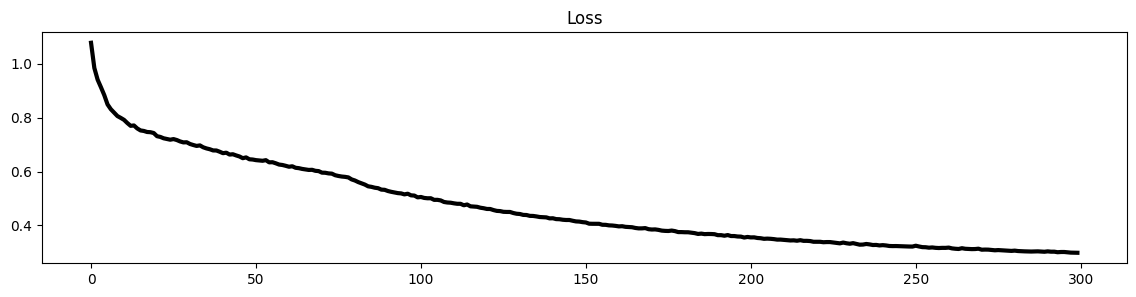

In [38]:
# Visualizing the loss function
plt.figure(figsize=(14, 3))
plt.plot(loss_history, 'k', lw=3)
plt.title('Loss')

In [39]:
# Set the model to eval state
_ = model.eval()

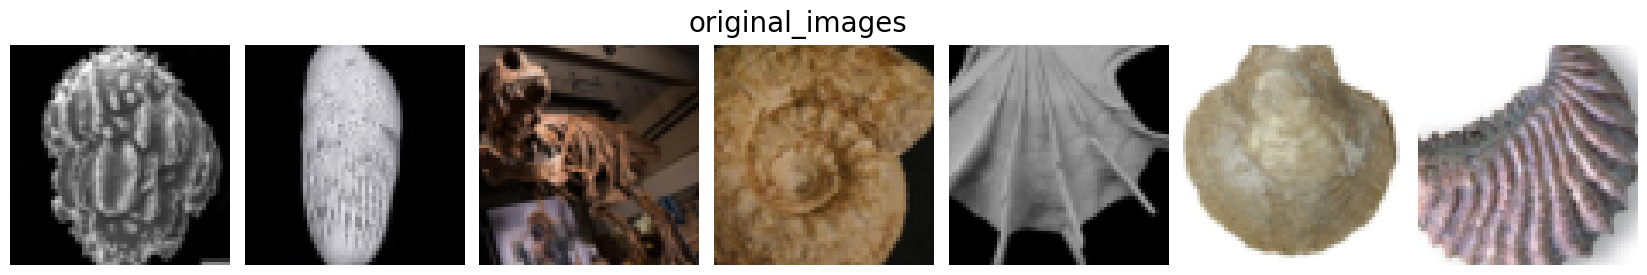

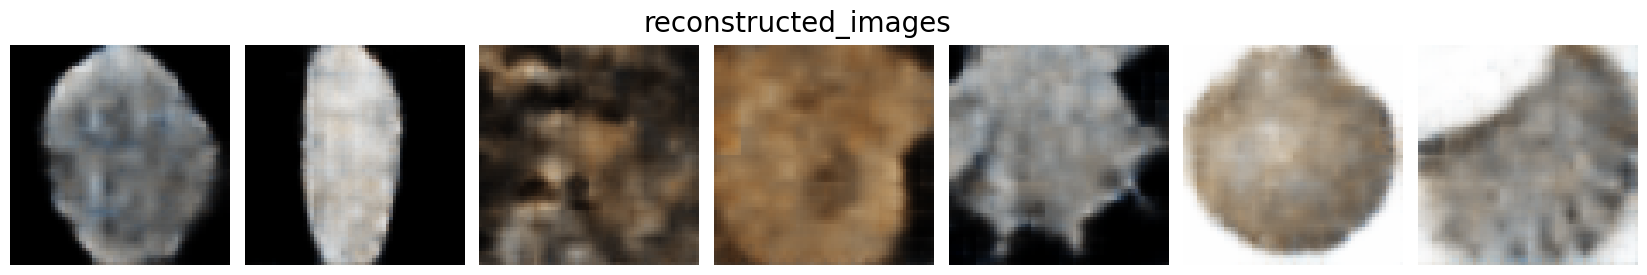

In [40]:
# Display some sample images and there reconstruction through autoencoders
images = []
cols, rows = 7, 1
for i in range(cols * rows):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img = training_data[sample_idx]
    images.append(img)
display_image_grid(images, rows, cols, "original_images")

with torch.no_grad():
    reconstructed_images = model(torch.stack(images).to(device))[0].cpu()
display_image_grid(reconstructed_images.squeeze(1), rows, cols, "reconstructed_images")

## Generation through Variational Autoencoders

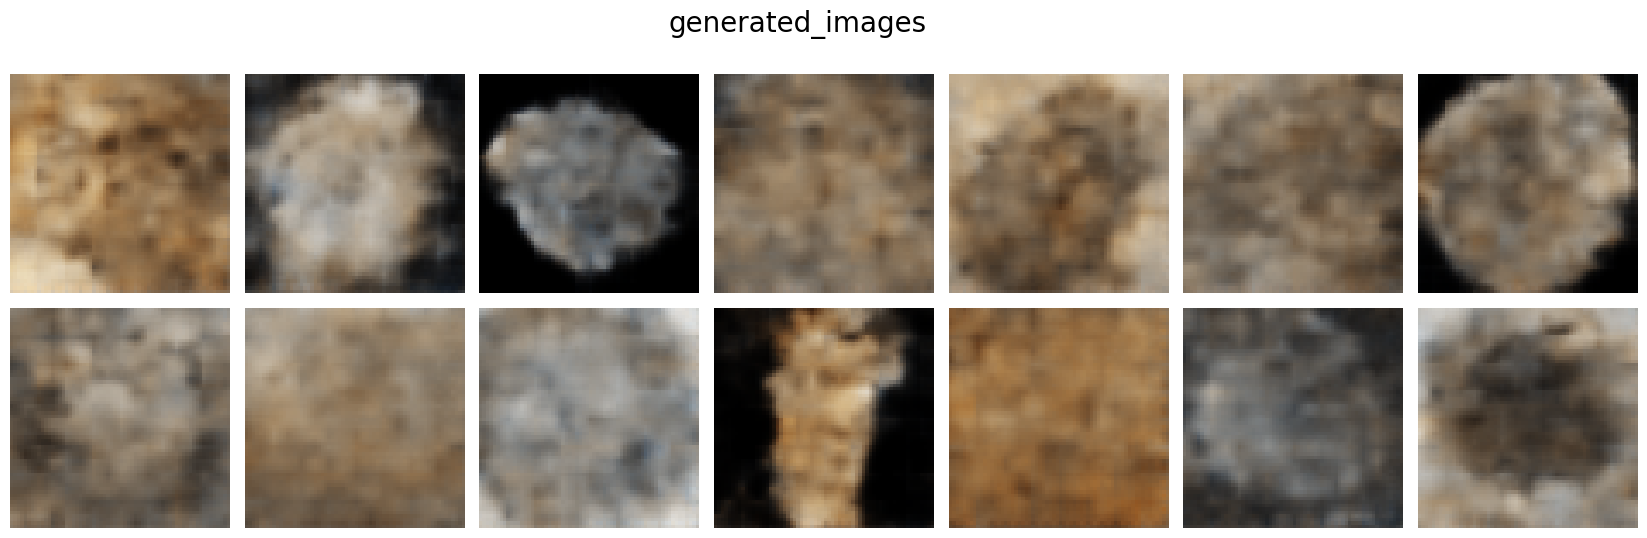

In [41]:
# Now we will try some actual generation. We will sample the encodings randomly and then pass them through decoder
rows, cols = 2, 7
sample_encodings = torch.randn(rows*cols, z).to(device)
with torch.no_grad():
    generations = model.decoder(sample_encodings).cpu()
display_image_grid(generations.squeeze(1), rows, cols, "generated_images")

With Variational Autoencoders, we sacrificed a little in reconstruction but in the end we got some decent generations from completely random inputs. But as it can be seen, they are blurry. This is one of the shortcommings of VAEs, that they produce blurry images.